# Step1. Feature Engineering 

In [1]:
# ____________________ for Colab _______________________________________
import sys
from google.colab import drive
drive.mount('/content/gdrive') 
sys.path.append('/content/gdrive/MyDrive/My_env')
# ____________________ for Colab _______________________________________

import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, RobustScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 


Mounted at /content/gdrive


## Functions

In [54]:
""" 결측치 확인 """
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치 존재 Column : {col}')
            print(f' -> {missing_values}개의 결측치 존재\n')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('* --- No missing values --- *')
    return missing_col


""" 컬럼별 분류 """
def classifying_features(df) : 
  cat_cols = [] 
  con_cols = [] 
  for col in df.columns : 
    if df[col].dtypes == "object" : 
      cat_cols.append(col)
    elif df[col].dtypes == "int64" :
      con_cols.append(col)
      
  return cat_cols, con_cols


""" Feature - target 간 관계 확인 """
def show_relations(feature) :
  temp_df = train[[feature, "target"]]
  feat_type = temp_df[feature].unique()
  feat_dic = {} 

  for i, feat in enumerate(feat_type) :
    idx = temp_df[feature] == feat
    feat_dic[feat] = np.mean(temp_df[idx]["target"])
  temp_df = pd.DataFrame(feat_dic, index = ["Rate"])
  temp_df = pd.DataFrame.transpose(temp_df)
  
  bar = temp_df.plot.bar(grid = False)
  bar.set_xlabel(feature)
  bar.set_ylabel("Target")
  bar.figsize = (2000, 600)


""" 이상치 찾기 """
def find_outlier(df = None, col_name = None) : 
  col = df[col_name]
  quantile_25 = np.percentile(col.values, 25)
  quantile_75 = np.percentile(col.values, 75)
  IQR = (quantile_75 - quantile_25) * 1.5
  low_value = quantile_25 - IQR
  high_value = quantile_75 + IQR
  outlier_idx = col[(col < low_value) | (col > high_value)].index
  return outlier_idx

  for con in con_cols :
    outlier_idx = find_outlier(df = train, col_name = con)
    print("-" * 100)
    print("{} outlier idex : ".format(con), outlier_idx.values, "\n")
    print("\n--> {} outlier value : {}\n".format(con, train[con][outlier_idx].values))


def feature_scaler(train_df, test_df, scaler, scaler_name) : 
  for con_col in con_cols : 

    scaler.fit(train_df[[con_col]])
    train_df[con_col + "#" + scaler_name] = scaler.transform(train_df[[con_col]])
    test_df[con_col + "#" + scaler_name] = scaler.transform(test_df[[con_col]])


""" One-Hot Encoding """ 
def oh_encoding(cat_cols, train, test) :

  for s, cat in enumerate(cat_cols) :
    oh_labels1 = pd.get_dummies(train[cat])    
    oh_labels2 = pd.get_dummies(test[cat])

    # train과 test 간 특정 칼럼에 존재하는 label이 다를 때.  
    comp = np.array_equal(np.sort(oh_labels1.columns), np.sort(oh_labels2.columns))
    if comp == False :
      vars1 = set(oh_labels1.columns) - set(oh_labels2.columns)
      for var in vars1 :
        oh_labels2[var] = np.full([test.shape[0]], 0)

    train = pd.concat((oh_labels1, train), axis = 1)
    train.drop(columns = [cat], axis = 1, inplace = True)

    test = pd.concat((oh_labels2, test), axis = 1)
    test.drop(columns = [cat], axis = 1, inplace = True)
  
  return train, test

## Data Setting

In [3]:
contest = "" 
dir = "/content/gdrive/MyDrive/ColabNotes/DACON/{}/data/".format(contest)
submission_file = "sample_submission.csv"
test_file = "test.csv"
train_file = "train.csv"    

submission = pd.read_csv(dir + submission_file)
test = pd.read_csv(dir + test_file)
train = pd.read_csv(dir + train_file)

## EDA

In [8]:
""" id열 제거 후 학습 데이터 탐색 """
train.drop(columns = ["id"], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             17480 non-null  int64 
 1   workclass       15644 non-null  object
 2   fnlwgt          17480 non-null  int64 
 3   education       17480 non-null  object
 4   education.num   17480 non-null  int64 
 5   marital.status  17480 non-null  object
 6   occupation      15637 non-null  object
 7   relationship    17480 non-null  object
 8   race            17480 non-null  object
 9   sex             17480 non-null  object
 10  capital.gain    17480 non-null  int64 
 11  capital.loss    17480 non-null  int64 
 12  hours.per.week  17480 non-null  int64 
 13  native.country  16897 non-null  object
 14  target          17480 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.0+ MB


In [15]:
print("* --- Show Train Data --- *\n")
train

* --- Show Train Data --- *



,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


In [10]:
""" id열 제거 후 테스트 데이터 탐색 """
test.drop(columns = ["id"], axis = 1, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15081 entries, 0 to 15080
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15081 non-null  int64 
 1   workclass       15081 non-null  object
 2   fnlwgt          15081 non-null  int64 
 3   education       15081 non-null  object
 4   education.num   15081 non-null  int64 
 5   marital.status  15081 non-null  object
 6   occupation      15081 non-null  object
 7   relationship    15081 non-null  object
 8   race            15081 non-null  object
 9   sex             15081 non-null  object
 10  capital.gain    15081 non-null  int64 
 11  capital.loss    15081 non-null  int64 
 12  hours.per.week  15081 non-null  int64 
 13  native.country  15081 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.6+ MB


In [16]:
print("* --- Show Test Data --- *\n")
test

* --- Show Test Data --- *



,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,47,Private,304133,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
1,34,Self-emp-inc,154227,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,75,United-States
2,31,Local-gov,158291,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,8614,0,40,United-States
3,28,Private,183155,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
4,54,Local-gov,182543,Some-college,10,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,30,Local-gov,182926,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,40,United-States
15077,39,Private,176101,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
15078,48,Private,242406,11th,7,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,Puerto-Rico
15079,44,Private,100584,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States


In [17]:
print("* ---Shape--- *")
print("train 데이터 : ", train.shape)
print("test 데이터 : ", test.shape)

* ---Shape--- *
train 데이터 :  (17480, 15)
test 데이터 :  (15081, 14)


In [23]:
# 학습 데이터 내 결측치 존재 여부
missing_col = check_missing_col(train)

결측치 존재 Column : workclass
 -> 1836개의 결측치 존재

결측치 존재 Column : occupation
 -> 1843개의 결측치 존재

결측치 존재 Column : native.country
 -> 583개의 결측치 존재



In [38]:
# # 결측 존재행 삭제 
# train = train.dropna()
# missing_col = check_missing_col(train)
# train.info()

* --- No missing values --- *
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15081 entries, 0 to 15080
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15081 non-null  int64 
 1   workclass       15081 non-null  object
 2   fnlwgt          15081 non-null  int64 
 3   education       15081 non-null  object
 4   education.num   15081 non-null  int64 
 5   marital.status  15081 non-null  object
 6   occupation      15081 non-null  object
 7   relationship    15081 non-null  object
 8   race            15081 non-null  object
 9   sex             15081 non-null  object
 10  capital.gain    15081 non-null  int64 
 11  capital.loss    15081 non-null  int64 
 12  hours.per.week  15081 non-null  int64 
 13  native.country  15081 non-null  object
 14  target          15081 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 1.8+ MB


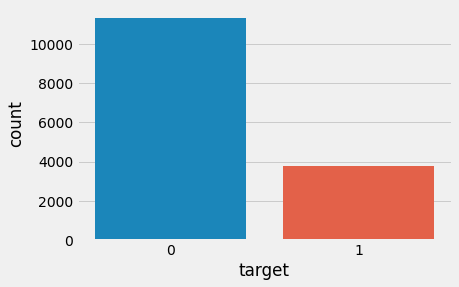

In [39]:
""" 데이터 불균형 확인 """ 
sns.countplot(x = train["target"])

In [40]:
cat_cols, con_cols = classifying_features(train)
print("범주형 변수들 : ", cat_cols)
print("\n연속형 변수들 : ", con_cols)

범주형 변수들 :  ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

연속형 변수들 :  ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'target']


In [41]:
print("* --- Show labels in Cat_vars --- *\n")
for col in cat_cols :
  print(col, " : ", train[col].unique(), "\n")

* --- Show labels in Cat_vars --- *

workclass  :  ['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay'] 

education  :  ['Assoc-acdm' 'Some-college' 'Bachelors' 'HS-grad' 'Prof-school' '10th'
 '11th' 'Masters' '7th-8th' '1st-4th' 'Assoc-voc' '5th-6th' 'Doctorate'
 '9th' '12th' 'Preschool'] 

marital.status  :  ['Married-civ-spouse' 'Never-married' 'Divorced' 'Separated'
 'Married-AF-spouse' 'Married-spouse-absent' 'Widowed'] 

occupation  :  ['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces'] 

relationship  :  ['Husband' 'Own-child' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative'] 

race  :  ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other'] 

sex  :  ['Male' 'Female'] 

native.country  :  ['United-States' 'Poland' 'Mexico' 'Ireland' 'Gu

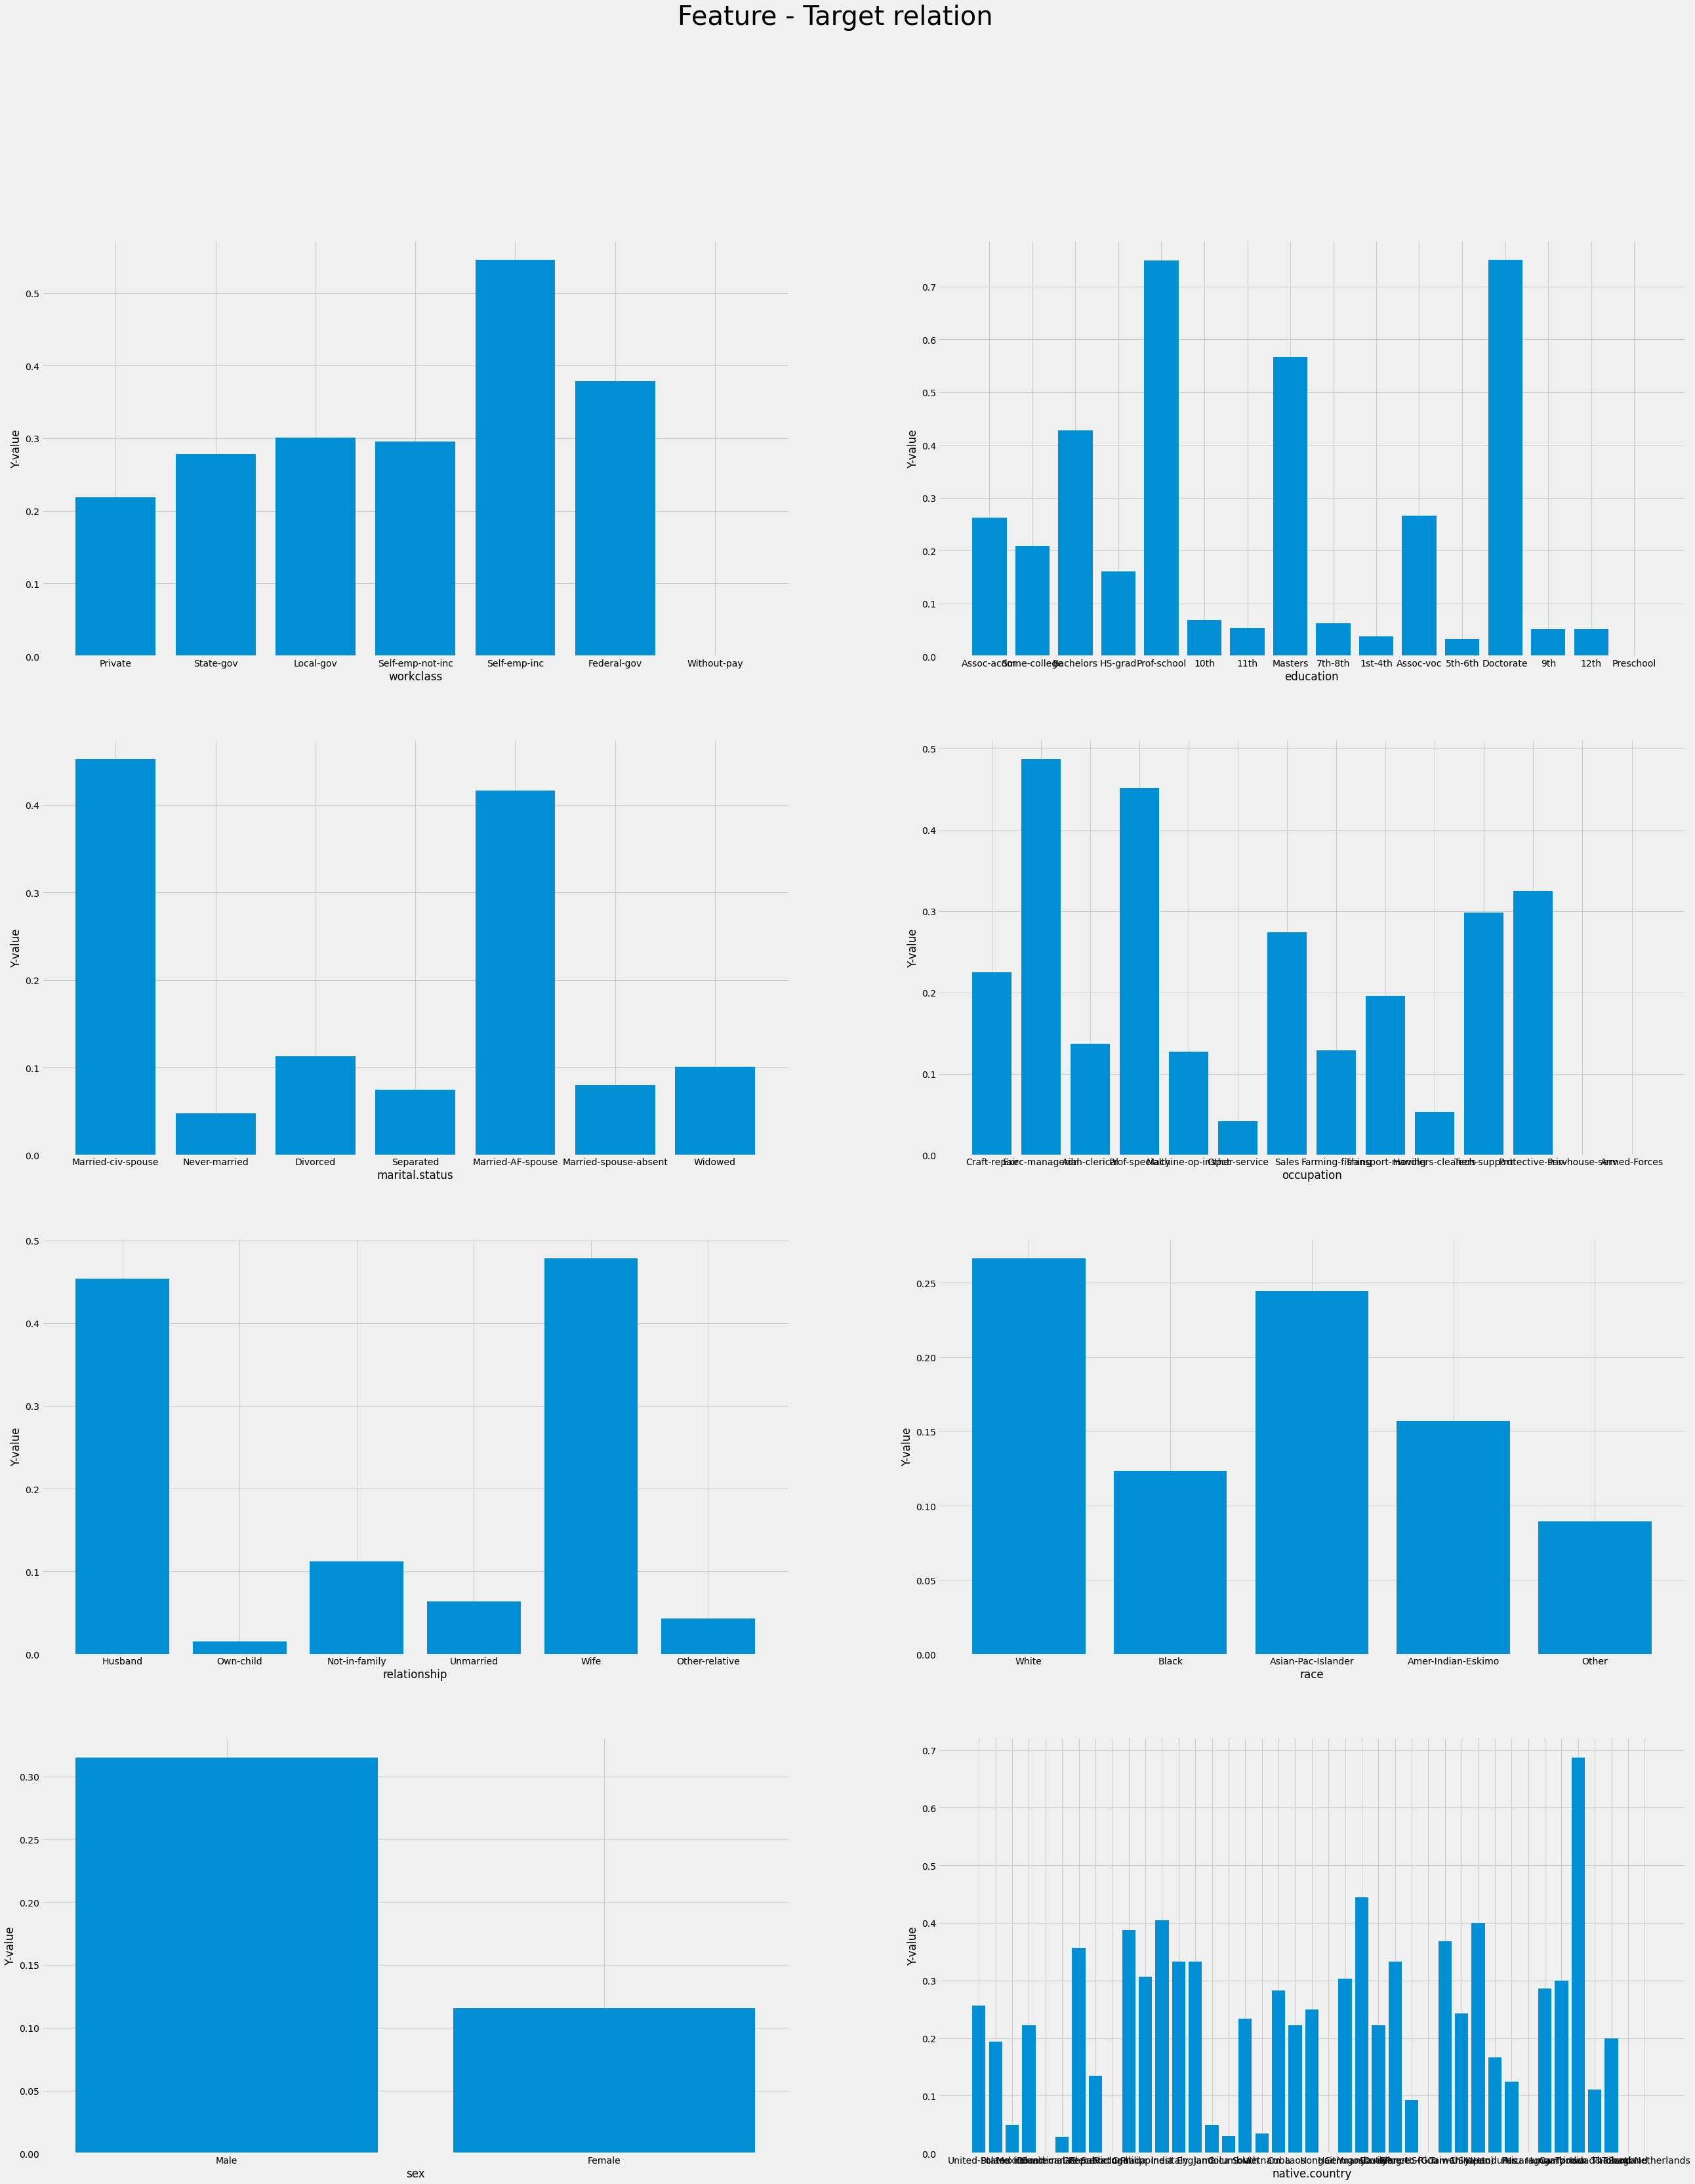

In [43]:
""" Relation of Features - Target """

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(4, 2, figsize = (40, 50))
fig.suptitle("Feature - Target relation", fontsize = 40)
col_idx = 0 

for i in range(4) :
  for j in range(2) :
    feat_type = cat_cols[col_idx]
    temp_df = train[[feat_type, "target"]]
    labels = temp_df[feat_type].unique()
    feat_values = []

    for label in labels :
      idx = temp_df[feat_type] == label
      feat_values.append(np.mean(temp_df[idx]["target"]))

    ax[i][j].bar(labels, feat_values) # Caution! : 결측치 존재 시 오류 발생
    ax[i][j].set_xlabel(feat_type)
    ax[i][j].set_ylabel("Y-value")
    col_idx += 1 

## Preprocessing

In [ ]:
""" 특정 coloumn의 label 종류 보기 """ 
summ_col = ""
train[summ_col].unique()

In [ ]:
# 특정 변수 제거 
drop_col = ""
train.drop(columns = [drop_col], axis = 1, inplace = True)
test.drop(columns = [drop_col], axis = 1, inplace = True)

In [48]:
print(" * --- 처리 후 변수 종류 --- *\n")
cat_cols, con_cols = classifying_features(train)
con_cols.remove('target')
print("cat_cols : ", cat_cols)
print("\ncon_cols : ", con_cols)

 * --- 처리 후 변수 종류 --- *

cat_cols :  ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

con_cols :  ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


In [52]:
""" Column별 이상치 찾기 """ 
print("* --- Show Outliers --- *\n")
for con in con_cols :
  outlier_idx = find_outlier(df = train, col_name = con)
  print("-" * 100)
  print("{} outlier idex : ".format(con), outlier_idx.values, "\n")
  print("\n--> {} outlier value : {}\n".format(con, train[con][outlier_idx].values))

* --- Show Outliers --- *

----------------------------------------------------------------------------------------------------
age outlier idex :  [   89   307   333   592   874  1047  1132  1220  1965  2239  2623  2798
  2945  3050  3115  3396  3572  3737  3826  3830  3844  3847  3849  3915
  4067  4184  4196  4400  4722  4920  5180  5222  5724  6027  6322  6759
  6899  7522  7598  7732  7770  7900  8320  8356  8389  8466  8923  9444
  9494  9509  9583  9835  9963 10050 10231 10242 10246 10305 10517 10845
 10853 11153 11272 11331 11407 11531 11686 11839 12096 12312 12422 13242
 13400 13452 13539 13559 13735 13798 14264 14311 14823 14844 14893] 


--> age outlier value : [79 76 76 76 77 90 86 77 78 77 78 77 76 82 76 90 81 76 82 79 90 85 78 82
 90 79 90 90 76 77 80 82 90 88 90 83 90 80 84 77 80 76 76 79 81 79 90 76
 85 90 81 80 81 80 88 76 90 90 77 79 90 90 90 76 79 76 90 90 81 77 81 83
 83 77 77 79 83 76 81 77 76 79 80]

----------------------------------------------------------------

In [ ]:
""" 특정 컬럼의 특정 조건 삭제 """
dirty_var = ""
outlier_idx = train[train[dirty_var] > 기준치]
train.drop(outlier_idx.index, inplace = True)

In [58]:
""" Scaling Features """ 

scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = QuantileTransformer()
scaler4 = RobustScaler()

feature_scaler(train, test, scaler1, "Scaler1")
feature_scaler(train, test, scaler2, "Scaler2")
feature_scaler(train, test, scaler3, "Scaler3")
feature_scaler(train, test, scaler4, "Scaler4")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [63]:
print("Shape of X_train : ", train.shape)
print("Shape of test : ", test.shape)

print("\n* --- Scaling 후 학습 데이터 --- *\n")
train.info()

Shape of X_train :  (15081, 21)
Shape of test :  (15081, 20)

* --- Scaling 후 학습 데이터 --- *

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15081 entries, 0 to 15080
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     15081 non-null  int64  
 1   workclass               15081 non-null  object 
 2   fnlwgt                  15081 non-null  int64  
 3   education               15081 non-null  object 
 4   education.num           15081 non-null  int64  
 5   marital.status          15081 non-null  object 
 6   occupation              15081 non-null  object 
 7   relationship            15081 non-null  object 
 8   race                    15081 non-null  object 
 9   sex                     15081 non-null  object 
 10  capital.gain            15081 non-null  int64  
 11  capital.loss            15081 non-null  int64  
 12  hours.per.week          15081 non-null  int64  
 13 

In [64]:
""" 결측 혹은 inf 존재 행 제거 """
train_cols = train.columns
for col in train_cols :
  if (train[col] == np.inf).any() :
    train.drop(columns = [col], axis = 1, inplace = True)
    test.drop(columns = [col], axis = 1, inplace = True)

missing_col = check_missing_col(train)

* --- No missing values --- *


In [65]:
""" 범주형 변수 One-Hot Encoding """
train, test = oh_encoding(cat_cols, train, test)

In [67]:
print("* ---Shape--- *")
print("train 데이터 : ", train.shape)
print("test 데이터 : ", test.shape)

* ---Shape--- *
train 데이터 :  (15081, 111)
test 데이터 :  (15081, 110)


In [68]:
# # """ SMOTE 실행 후 학습 데이터에서 Target 제거 """
# smote = SMOTE(random_state = 124)
# X_train, Y_train = smote.fit_resample(train, train["target"])
# X_train.drop(columns = ["target"], axis = 1, inplace = True)

In [ ]:
# # """ Non SMOTE & 학습 데이터에서 Target 제거 """
# X_train = train.drop(columns = ["target"], axis = 1)
# Y_train = train["target"]

In [74]:
print("* --- 학습 데이터 features --- *")
X_train.head()

* --- 학습 데이터 features --- *


,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,...,education.num,capital.gain,capital.loss,hours.per.week,age#Scaler1,fnlwgt#Scaler1,education.num#Scaler1,capital.gain#Scaler1,capital.loss#Scaler1,hours.per.week#Scaler1
0,0,0,0,0,0,0,0,0,0,0,...,12,0,0,40,-0.490640,1.139059,0.736461,-0.147567,-0.21493,-0.076620
1,0,0,0,0,0,0,0,0,0,0,...,10,0,0,40,-0.414639,0.149179,-0.043193,-0.147567,-0.21493,-0.076620
2,0,0,0,0,0,0,0,0,0,0,...,10,0,0,40,0.573379,-0.379041,-0.043193,-0.147567,-0.21493,-0.076620
3,0,0,0,0,0,0,0,0,0,0,...,13,0,0,30,-1.174652,0.031405,1.126288,-0.147567,-0.21493,-0.908697
4,0,0,0,0,0,0,0,0,0,0,...,9,0,0,40,1.257391,-1.232984,-0.433021,-0.147567,-0.21493,-0.076620


In [73]:
print("* --- 학습 데이터 target --- *")
Y_train.head()

* --- 학습 데이터 target --- *


0    0
1    1
2    0
3    0
4    0
Name: target, dtype: int64

* --- Target 분포 --- *



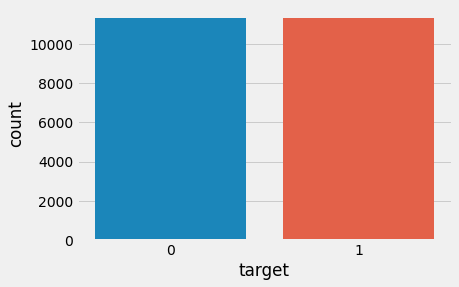

In [78]:
print("* --- Target 분포 --- *\n")
sns.countplot(x = Y_train)

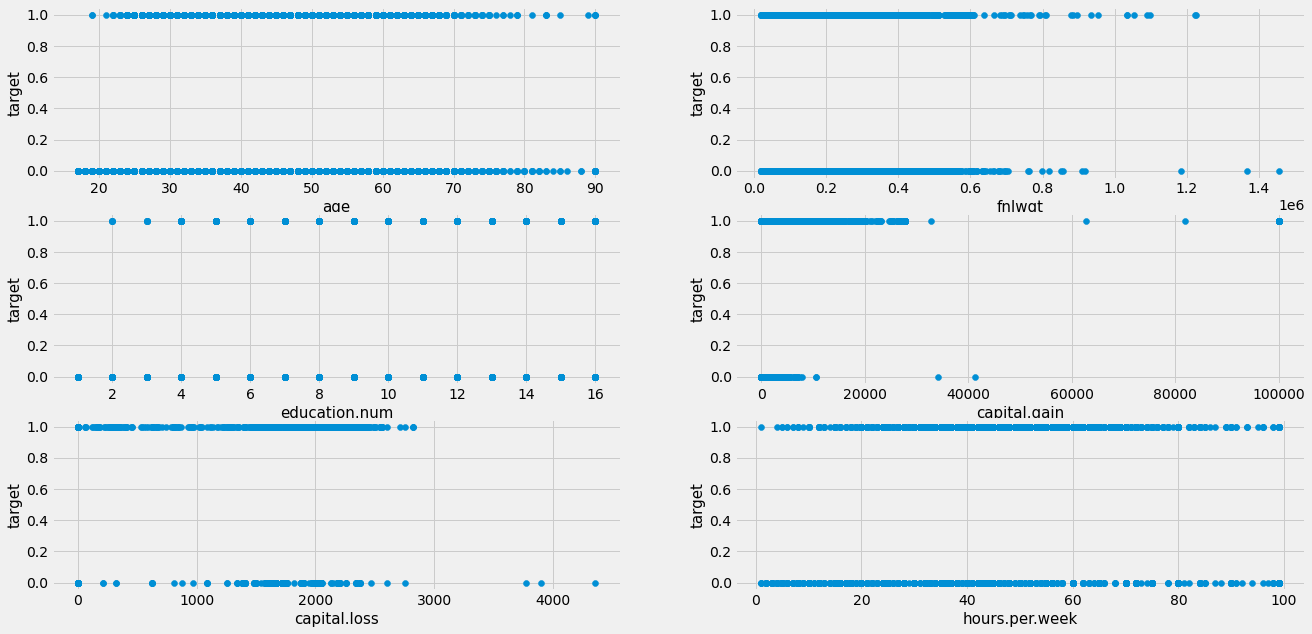

In [79]:
""" Correlation Heatmap """
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(3, 2, figsize = (20, 10))
col_idx = 0 

for i in range(3) :
  for j in range(2) :
    try : 
      con = con_cols[col_idx]
      ax[i][j].set_xlabel(con, fontsize = 15)
      ax[i][j].set_ylabel("target", fontsize = 15)
      ax[i][j].scatter(X_train[con], Y_train)
    except : 
      break 
      
    col_idx += 1 

In [80]:
""" Train & Test 데이터 간 컬럼 순서 통일 """
train_col = list(X_train.columns.values)
test = test[train_col]
np.array_equal(X_train.columns, test.columns)

True

In [81]:
print("Shape of X_train : ", X_train.shape)
print("Shape of test : ", test.shape)

Shape of X_train :  (22616, 110)
Shape of test :  (15081, 110)


In [ ]:
""" 수정한 데이터 파일 저장 """ 

X_train.to_csv(dir + "X_train.csv", index = False)
Y_train.to_csv(dir + "Y_train.csv", index = False)
test.to_csv(dir + "test_renew.csv", index = False)